### Identify cells that are positive for Itga3 and Src
* Determine if these cells are enriched in early-stage AT2-KRAS cells across species

In [1]:
import os
import glob
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from seaborn import despine
from seaborn import axes_style
import magic # imputation tool; van Dijk et al 2018 # 
from matplotlib.pyplot import suptitle
import matplotlib.colors
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch # for clustermap legends
import time

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Reload data

# MOUSE
subset_results_file = 'path/to/h5ad'
mouse = sc.read(subset_results_file)

# ORGANOID
at2_results_file = 'path/to/h5ad'
orgs = sc.read(at2_results_file)

# HUMAN
results_file2 = 'path/to/h5ad'
human = sc.read(results_file2)

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


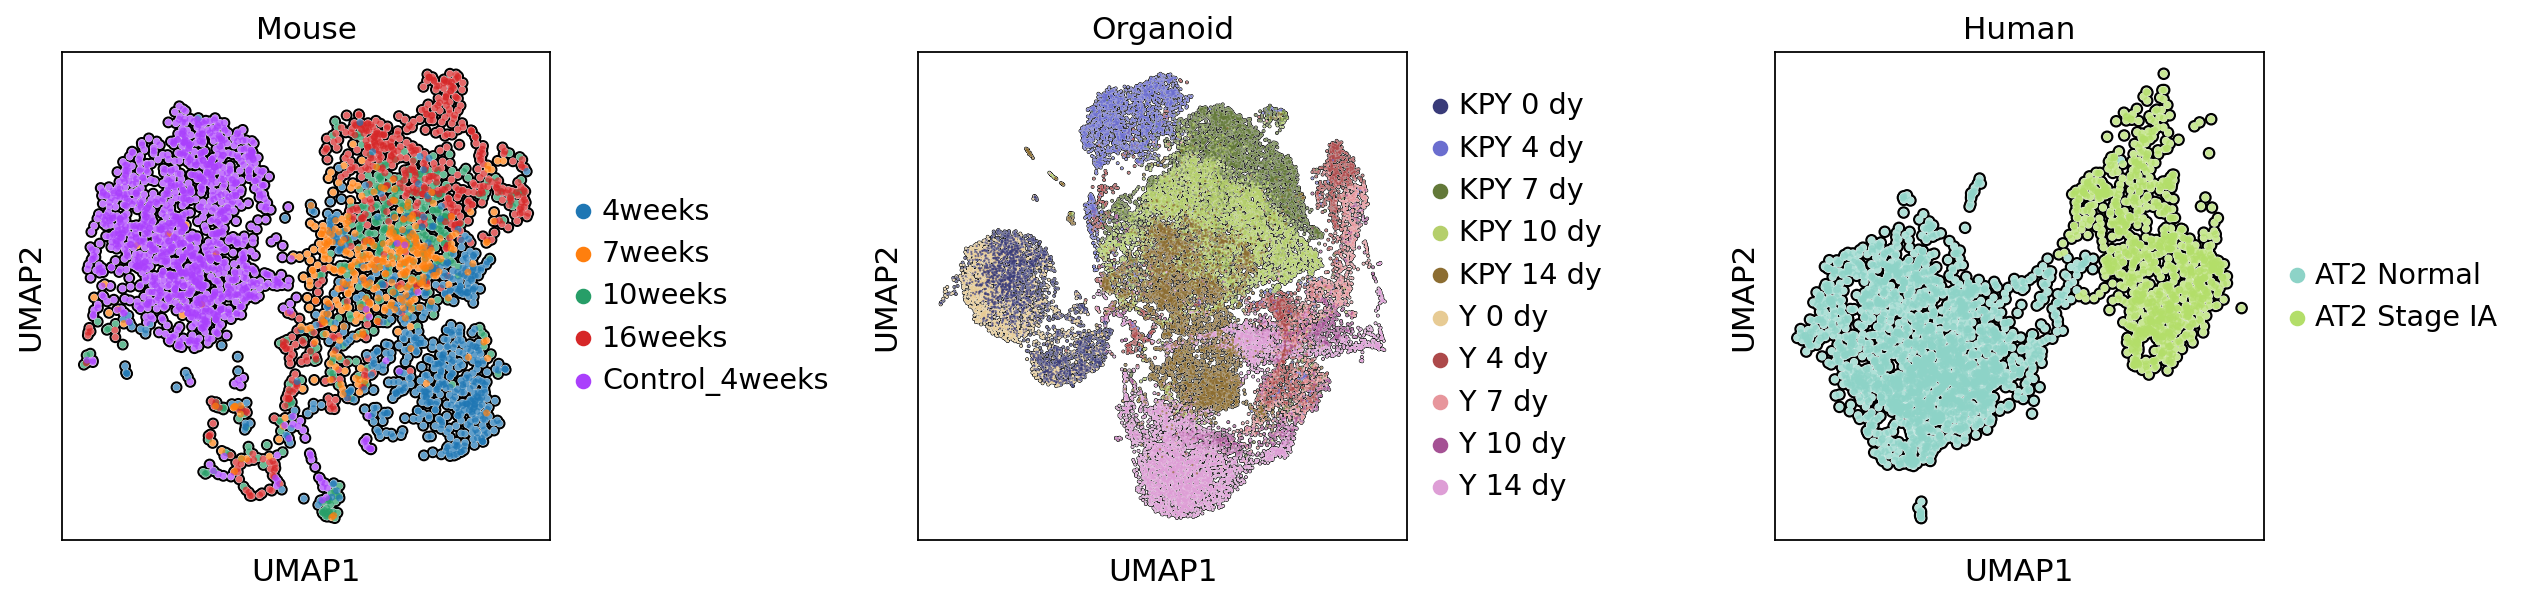

In [4]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

# Ensure Scanpy knows about the matplotlib context
sc.set_figure_params(figsize=(4,3), facecolor='white')

# Plot the UMAP plots
sc.pl.umap(mouse, color=['time_point'], add_outline=True, frameon=True, ax=axes[0], show=False, title='Mouse')
sc.pl.umap(orgs, color=['yfp_time_annot'], add_outline=True, frameon=True, ax=axes[1], show=False, title = 'Organoid')
sc.pl.umap(human, color=['annot'], add_outline=True, frameon=True, ax=axes[2], show=False, title = 'Human', palette=['#8dd3c7', '#b3de69']) # match colors

# Display the figure
plt.tight_layout()
plt.show()

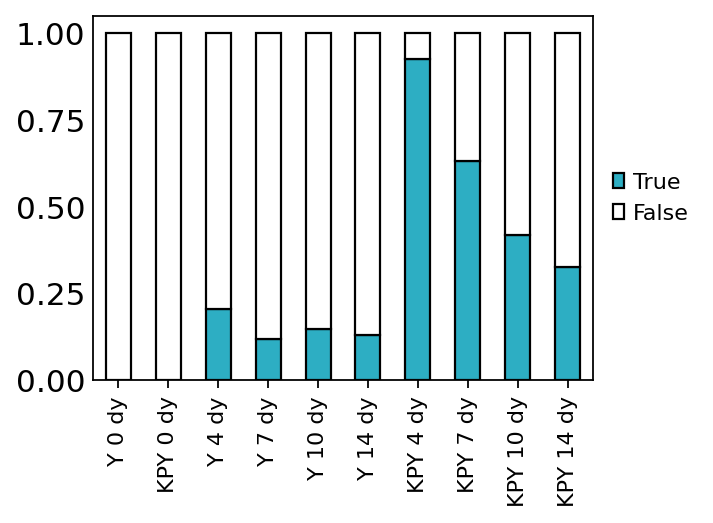

In [10]:
genes = ['Itga3','Src']

for gene in genes:
    df.obs[gene]=df[:, [gene]].to_df() 
    
# Annotate cells as epithelial or mesenchymal for future analysis and plotting.
# Batch allocation is based on FACS gating.

scores = df.obs[['Itga3','Src']]

annotation = pd.Series('False', index=scores.index)

# Add annotations
annotation[(scores['Itga3'] > 0) & (scores['Src'] > 0)] = 'True' 
df.obs['Itga3_DP'] = annotation

df_plot = df.obs.groupby(['yfp_time_annot','Itga3_DP']).size().reset_index().pivot(columns='Itga3_DP', index='yfp_time_annot', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

order = ['True','False']
df3 = df3[order]

# Manually order the rows according to yfpStatus contributions
df3 = df3.reindex(['Y 0 dy','KPY 0 dy','Y 4 dy','Y 7 dy','Y 10 dy','Y 14 dy','KPY 4 dy','KPY 7 dy','KPY 10 dy','KPY 14 dy'])

# plot
color = ['#2DAEC3','white']

rcParams['figure.figsize'] = 4,3
with axes_style({'axes.grid': False}):
    ax = df3.plot(kind='bar', stacked=True, edgecolor='black', color = color
                 )
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    ax.set_xlabel("", rotation=0, labelpad=10, fontsize=10)
    ax.set_ylabel("", rotation=90, labelpad=10, fontsize=10)
    ax.set_xticklabels(df3.index, fontsize=10)
    #ax.set_yticklabels([0.0,0.5,1.0], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    #despine(right=True, left=True)

#### GEMM

In [11]:
df2 = sc.pp.scale(mouse, copy=True)

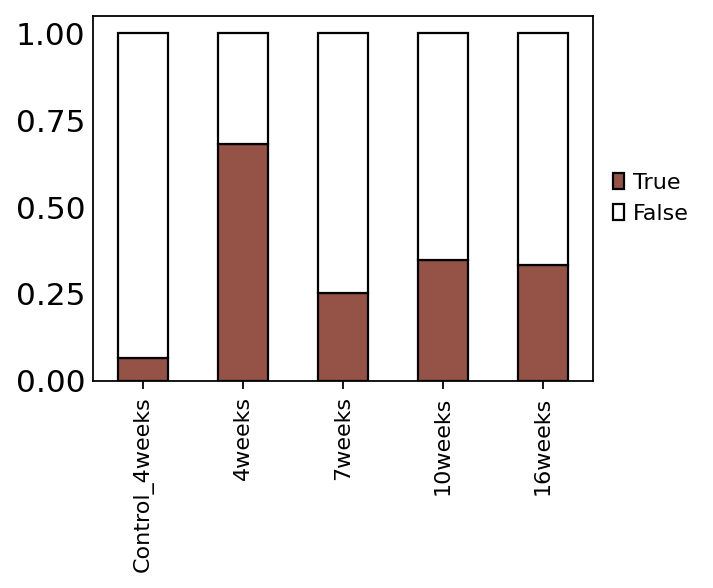

In [13]:
genes = ['Itga3','Src']

for gene in genes:
    df2.obs[gene]=df2[:, [gene]].to_df() 
    
# Annotate cells as epithelial or mesenchymal for future analysis and plotting.
# Batch allocation is based on FACS gating.

scores = df2.obs[['Itga3','Src']]

annotation = pd.Series('False', index=scores.index)

# Add annotations
annotation[(scores['Itga3'] > 0) & (scores['Src'] > 0)] = 'True' 
df2.obs['Itga3_DP'] = annotation

df2_plot = df2.obs.groupby(['time_point','Itga3_DP']).size().reset_index().pivot(columns='Itga3_DP', index='time_point', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df23 = df2_plot.div(df2_plot.sum(axis=1), axis=0)

order = ['True','False']
df23 = df23[order]

# Manually order the rows according to yfpStatus contributions
df23 = df23.reindex(['Control_4weeks','4weeks', '7weeks','10weeks', '16weeks'])

# plot

color = ['#955348','white']

rcParams['figure.figsize'] = 4,3
with axes_style({'axes.grid': False}):
    ax = df23.plot(kind='bar', stacked=True, edgecolor='black', color = color
                 )
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    ax.set_xlabel("", rotation=0, labelpad=10, fontsize=10)
    ax.set_ylabel("", rotation=90, labelpad=10, fontsize=10)
    ax.set_xticklabels(df23.index, fontsize=10)
    #ax.set_yticklabels([0.0,0.5,1.0], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    #despine(right=True, left=True)

### Human

In [14]:
df3 = sc.pp.scale(human, copy=True)

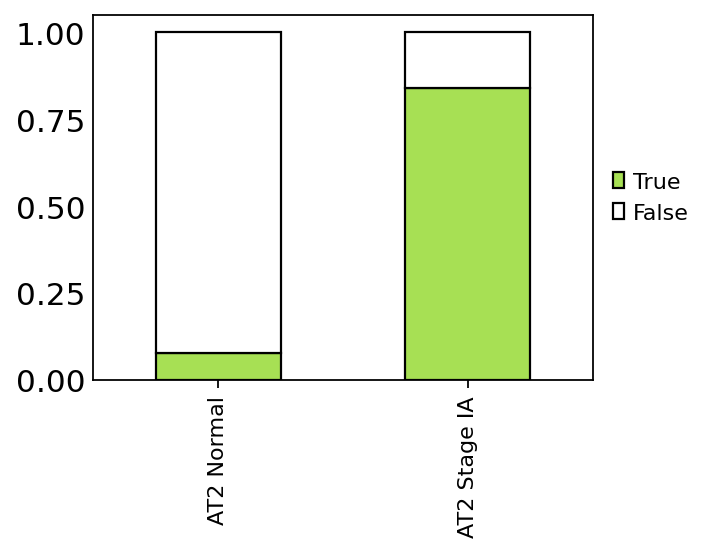

In [16]:
genes = ['ITGA3','SRC']

for gene in genes:
    df3.obs[gene]=df3[:, [gene]].to_df() 
    
# Annotate cells as epithelial or mesenchymal for future analysis and plotting.
# Batch allocation is based on FACS gating.

scores = df3.obs[['ITGA3','SRC']]

annotation = pd.Series('False', index=scores.index)

# Add annotations
annotation[(scores['ITGA3'] > 0) & (scores['SRC'] > 0)] = 'True' 
df3.obs['ITGA3_DP'] = annotation

df3_plot = df3.obs.groupby(['annot','ITGA3_DP']).size().reset_index().pivot(columns='ITGA3_DP', index='annot', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df23 = df3_plot.div(df3_plot.sum(axis=1), axis=0)

order = ['True','False']
df23 = df23[order]

# Manually order the rows according to yfpStatus contributions
df23 = df23.reindex(['AT2 Normal', 'AT2 Stage IA'])

# plot

color = ['#A7E054','white']

rcParams['figure.figsize'] = 4,3
with axes_style({'axes.grid': False}):
    ax = df23.plot(kind='bar', stacked=True, edgecolor='black', color = color
                 )
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    ax.set_xlabel("", rotation=0, labelpad=10, fontsize=10)
    ax.set_ylabel("", rotation=90, labelpad=10, fontsize=10)
    ax.set_xticklabels(df23.index, fontsize=10)
    #ax.set_yticklabels([0.0,0.5,1.0], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    #despine(right=True, left=True)